# Sampling from a GP

## Preliminary steps

### Loading necessary packages

In [1]:
using Plots
using AugmentedGaussianProcesses
using Distributions
using LinearAlgebra

### Generating some random data

In [2]:
kernel = SqExponentialKernel()
x = range(0, 10; length=50)
K = kernelmatrix(kernel, x)
f = rand(MvNormal(K + 1e-8I)) # Sample a random GP
y = rand.(Bernoulli.(AGP.logistic.(f)))
y_sign = Int.(sign.(y .- 0.5))

50-element Vector{Int64}:
 -1
  1
  1
  1
 -1
  1
  1
  1
  1
  1
  ⋮
 -1
 -1
 -1
 -1
 -1
  1
  1
  1
  1

### We create a function to visualize the data

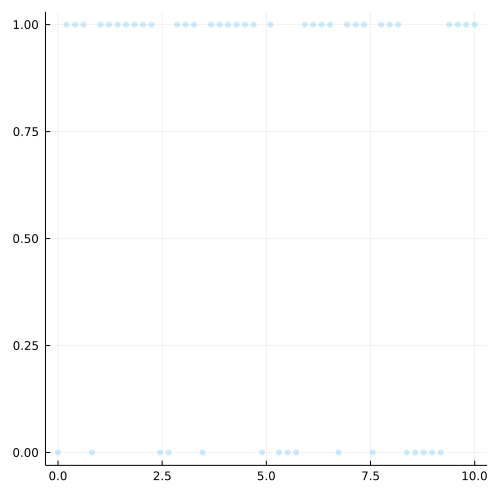

In [3]:
function plot_data(x, y; size=(300, 500))
    return Plots.scatter(x, y; alpha=0.2, markerstrokewidth=0.0, lab="", size=size)
end
plot_data(x, y; size=(500, 500))

### Run the variational gaussian process approximation

In [4]:
@info "Running full model"
mfull = VGP(x, y_sign, kernel, LogisticLikelihood(), AnalyticVI(); optimiser=false)
@time train!(mfull, 5)

[ Info: Running full model
  1.028932 seconds (1.82 M allocations: 103.699 MiB, 99.59% compilation time)


(Variational Gaussian Process with a BernoulliLikelihood{GPLikelihoods.LogisticLink}(GPLikelihoods.LogisticLink()) infered by Analytic Variational Inference , (local_vars = (c = [0.8207611732560307, 0.8560850425394804, 0.9245540293738744, 1.0135272755454168, 1.104693016176833, 1.1806170689575262, 1.2276986489927504, 1.2390367519386638, 1.214943191477269, 1.1628099666962706  …  0.6005420268757351, 0.6121105570511072, 0.631667489852353, 0.6346379150590581, 0.6196650142258366, 0.6095283814548621, 0.6366458124263618, 0.7131029531284714, 0.8191796379257971, 0.9244692753971562], θ = [0.2368507411227019, 0.2357733742183719, 0.2335927423257827, 0.23059061237150721, 0.22733772970769214, 0.22450864317807406, 0.22270573519098313, 0.22226645179583962, 0.2231976135732962, 0.22518118431655745  …  0.24274787960917601, 0.24247596534598054, 0.24200622432847407, 0.24193378082427883, 0.24229600511443108, 0.24253704422599268, 0.24188464897326606, 0.23991828302337245, 0.23689818848283173, 0.233595513921249

### We can also create a sampling based model

In [5]:
@info "Sampling from model"
mmcmc = MCGP(x, y, kernel, LogisticLikelihood(), GibbsSampling(); optimiser=false)
m = mmcmc
@time samples = sample(mmcmc, 1000)

[ Info: Sampling from model
Sampling with Gibbs Sampler   0%|                       |  ETA: N/A
Sampling with Gibbs Sampler   0%|▏                      |  ETA: 0:06:08
Sampling with Gibbs Sampler   1%|▎                      |  ETA: 0:03:06
Sampling with Gibbs Sampler   1%|▍                      |  ETA: 0:02:04
Sampling with Gibbs Sampler   2%|▍                      |  ETA: 0:01:32
Sampling with Gibbs Sampler   2%|▌                      |  ETA: 0:01:14
Sampling with Gibbs Sampler   3%|▋                      |  ETA: 0:01:01
Sampling with Gibbs Sampler   3%|▊                      |  ETA: 0:00:52
Sampling with Gibbs Sampler   4%|▉                      |  ETA: 0:00:46
Sampling with Gibbs Sampler   4%|█                      |  ETA: 0:00:40
Sampling with Gibbs Sampler   5%|█                      |  ETA: 0:00:36
Sampling with Gibbs Sampler   5%|█▏                     |  ETA: 0:00:33
Sampling with Gibbs Sampler   5%|█▎                     |  ETA: 0:00:30
Sampling with Gibbs Sampler   6%|█▍     

1000-element Vector{Vector{Vector{Float64}}}:
 [[0.7923123001190431, 0.9952821692586371, 1.1821244521014926, 1.3116461100706491, 1.4597621388457052, 1.5384381117349513, 1.5323805663921324, 1.4659037606744412, 1.2928961477652965, 1.028207680044835  …  0.3489888790878649, 0.22019090024562174, 0.23778030115352156, 0.333688086451915, 0.4422333749900008, 0.5255499944121809, 0.5562288448854278, 0.5192050557888392, 0.48335191353333545, 0.45348465287211126]]
 [[0.8681776920884519, 0.945255883349452, 0.987641847370119, 1.009454192829888, 0.980718521619372, 0.9502433522569826, 0.9481228380791045, 0.9564836457891163, 0.9958695684221139, 1.0244612377715943  …  -0.5618011349982784, -0.7745388992108188, -0.8218576309633756, -0.6840518792841619, -0.39576319056387754, -0.022395577750824625, 0.40284508434206173, 0.8056139827927233, 1.1068302543794917, 1.342883224600562]]
 [[0.5081901845350141, 0.7376364711008523, 0.9476486805513864, 1.0888556611587294, 1.128793166797411, 0.997729808181048, 0.7713896167

### We can now visualize the results of both models

### We first plot the latent function f (truth, the VI estimate, the samples)

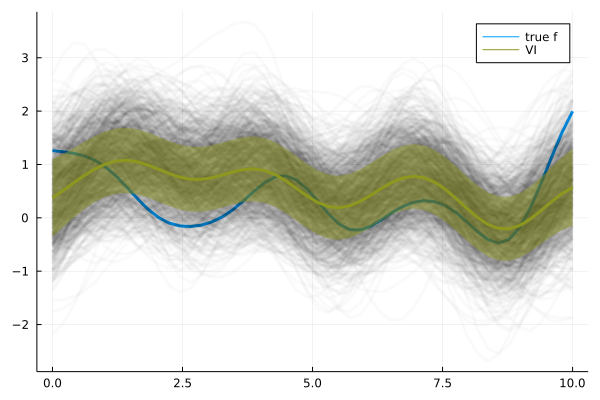

In [6]:
p1 = plot(x, f; label="true f")
plot!(x, samples; label="", color=:black, alpha=0.02, lab="")
plot!(x, mean(mfull[1]); ribbon=sqrt.(var(mfull[1])), label="VI")

### And we can also plot the predictions vs the data

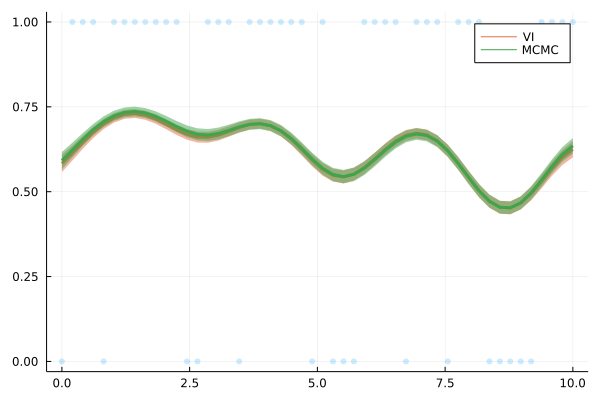

In [7]:
p2 = plot_data(x, y; size=(600, 400))
μ_vi, σ_vi = proba_y(mfull, x)
plot!(x, μ_vi; ribbon=σ_vi, label="VI")
μ_mcmc, σ_mcmc = proba_y(mmcmc, x)
plot!(x, μ_mcmc; ribbon=σ_mcmc, label="MCMC")

---

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*